### 알파제로를 분석하며 배우는 인공지능 Jpub AI22
Chapter 3-4 Resnet 을 활용한 이미지 분류
Cifar 10 classfication

Resnet Papers
https://arxiv.org/abs/1512.03385
https://arxiv.org/abs/1603.05027


In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation,Add,BatchNormalization,Conv2D,Dense,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_images,train_labels),(test_images,test_labels)=cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


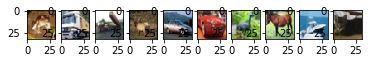

In [3]:
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_images[i])
plt.show()

In [4]:
#data preprocessing
train_images=train_images.astype('float32')/255.0
test_images=test_images.astype('float32')/255.0
train_labels=to_categorical(train_labels,10)
test_labels=to_categorical(test_labels,10)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


Using Functional API of Keras
DESC:

model=Sequential()
model.add(Dense(256,activation='sigmoid',input_shape=(784,))
model.add(Dense(128,activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

Becomes

input=Input(shape=(784,))
x=Dense(256,activation='sigmoid')(input)
x=Dense(128,activation='sigmoid')(x)
x=Dropout(0.5)(x)
x=Dense(10,activation='softmax')(x)

model=Model(inputs=input,outputs=x)


In [5]:
def conv(filters,kernel_size,strides=1):
    return Conv2D(filters,kernel_size,strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))


In [6]:
def first_residual_unit(filters,strides):
    """
    First Residual_block_unit Implementation
    
    """
    def f(x):
        #BN -> RELU
        x=BatchNormalization()(x)
        b=Activation('relu')(x)
        
        #conv layer -> BN -> RELU
        x=conv(filters//4,1,strides)(b)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        #conv layer ->BN ->RELU
        x=conv(filters//4,3)(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        #conv layer ->
        x=conv(filters,1)(x)
        
        #short cut manipulation
        sc=conv(filters,1,strides)(b)
        return Add()([x,sc])
    return f

In [7]:
def residual_unit(filters):
    """
    Residual Block B
    """
    def f(x):
        sc=x
        # -> BN -> RELU
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        # conv -> BN -> relu
        x=conv(filters//4,1)(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        #conv -> BN -> ReLu
        x=conv(filters//4,3)(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        # conv layer ->
        x=conv(filters,1)(x)
        return Add()([x,sc])
    return f


In [8]:
def residual_block(filters,strides,unit_size):
    def f(x):
        x=first_residual_unit(filters,strides)(x)
        for i in range(unit_size-1):
            x=residual_unit(filters)(x)
        return x
    return f


In [9]:
# 1 Input Layer
input=Input(shape=(32,32,3))

# 2 Conv layer
x=conv(16,3)(input)

# 3 Residual block 54
x=residual_block(64,1,18)(x)
x=residual_block(128,2,18)(x)
x=residual_block(256,2,18)(x)
 
# 4 BN->RELU
x=BatchNormalization()(x)
x=Activation('relu')(x)

# 5 Pooling
x=GlobalAveragePooling2D()(x)
output=Dense(10,activation='softmax',kernel_regularizer=l2(0.0001))(x)
model=Model(inputs=input,outputs=output)


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['acc'])


In [11]:
# Image DataGenerator 준비
train_gen=ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True
)
test_gen=ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

for data in (train_gen,test_gen):
    data.fit(train_images)
print(data)


In [12]:
def step_decay(epoch):
    x=0.1
    if epoch>=80: 
        x=0.01
    if epoch>=120: 
        x=0.001
    return x
lr_decay=LearningRateScheduler(step_decay)


In [13]:
batch_size=64
history=model.fit_generator(
    train_gen.flow(
        train_images,
        train_labels,
        batch_size=batch_size),
    epochs=10,
    steps_per_epoch=train_images.shape[0]//batch_size,
    validation_data=test_gen.flow(
            test_images,
            test_labels,
            batch_size=batch_size),
    validation_steps=test_images.shape[0]//batch_size,
    callbacks=[lr_decay]
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
782/782 [==============================] - 279s 357ms/step - loss: 3.9989 - acc: 0.2372 - val_loss: 3.2343 - val_acc: 0.1783
Epoch 2/10
782/782 [==============================] - 256s 327ms/step - loss: 1.9756 - acc: 0.2981 - val_loss: 10.4286 - val_acc: 0.1108
Epoch 3/10
782/782 [==============================] - 256s 327ms/step - loss: 1.8628 - acc: 0.3122 - val_loss: 1.9571 - val_acc: 0.2886
Epoch 4/10
782/782 [==============================] - 256s 327ms/step - loss: 1.8462 - acc: 0.3215 - val_loss: 2.0079 - val_acc: 0.2704
Epoch 5/10
782/782 [==============================] - 255s 326ms/step - loss: 1.8436 - acc: 0.3172 - val_loss: 2.5229 - val_acc: 0.1669
Epoch 6/10
782/782 [==============================] - 254s 325ms/step - loss: 1.8369 - acc: 0.3242 - val_loss: 3.9910 - val_acc: 0.1254
Epoch 7/10
782/782 [==============================] - 255s 326ms/step - loss: 1.8573 - acc: 0.3174 - val_loss: 2.6251 - val_acc: 0.2129

In [14]:
model.save('resnet.h5')


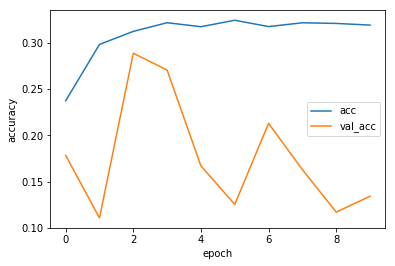

In [16]:
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [17]:
batch_size=64
test_loss,test_acc=model.evaluate_generator(
    test_gen.flow(test_images,test_labels,batch_size=batch_size),
    steps=10
)
print('loss: {:3f}\nacc: {:3f}'.format(test_loss,test_acc))


loss: 2.884887
acc: 0.134200
